# Denoising Diffusion Models

The following is based on the paper [Denoising Diffusion models](https://arxiv.org/abs/2006.11239). This notebook consists of three parts: an explanation of how the code models the paper, two implementations of the denoising diffusion model, and a short commentary.

# Introduction and Theory

The denoising diffusion model consists of two processes: a forward and reverse, where the forward process consists of "diffusing" the data and the reverse consists of "denoising" this diffusion. Once the model has been trained, we can feed the denoiser Gaussian noise to obtain realistic looking data.

Let the initial data be $x_0$, and let $x_1,...,x_T$ be the data at some "time" $t$ in the forward or reverse process.

The reverse process is the joint distribution $p_\theta(x_{0:T})$, defined as a Markov chain with learned Gaussian transitions beginning at $T$, the final "time", where $p(x_T)=N(x_T;0,I)$. So we have:
$$p_\theta(x_{0:T})=p(x_T)\prod_{t=1}^Tp_\theta(x_{t-1}|x_t)$$
$$p_\theta(x_{t-1}|x_t)=N(x_{t-1};\mu_\theta(x_t,t),\Sigma_\theta(x_t,t))$$

Our forward process $q$ is a Markov chain which adds Gaussian noise, approximating the posterior: $$q(x_{1:T}|x_0)=\prod_{t=1}^Tq(x_t|x_{t-1})$$
$$\begin{equation}
q(x_t|x_t-1)=N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)
\end{equation}$$

One useful aspect of the model is that we can easily sample at any time $t$. Letting $\alpha_t:=1-\beta_t$ and $\bar\alpha_t:=\prod_{s=1}^t\alpha_s$, we have that
$$q(x_t|x_0)=N(x_t;\sqrt{\bar\alpha_t}x_0, (1-\bar\alpha_t)I)\tag{1}$$
This result follows cleanly by induction on $t$.

To train the model, we use the [ELBO loss](https://en.wikipedia.org/wiki/Evidence_lower_bound). So we have:
$$\int_{x_1,...,x_T}\textrm{log}\left[ \frac{\prod_{t=1}^Tp_{t-1|t}(x_{t-1}|x_t;\theta)p_T(x_T)}{\prod_{t=1}^Tq_{t|t-1}(x_t|x_{t-1})} \right]\prod_{t=1}^Tq_{t|t-1}(x_t|x_{t-1})dx_1...dx_T$$

Manipulating this into something more tractable takes several steps. By switching the sum and the integral, then marginalizing out certain terms in the integral, we can reduce this to:
$$=\sum_{t=1}^T\int_{x_{t-1},x_t}\textrm{log} \frac{p_{t-1|t}(x_{t-1}|x_t;\theta)}{q_{t|t-1}(x_t|x_{t-1})}q_{t-1,t|0}(x_t,x_{t-1}|x_0)dx_{t-1}dx_t$$
$$+\int_{x_T}\textrm{log}p_T(x_T)q_T(x_T|x_0)dx_T$$.

Next, we rewrite the integral as an expectation and use the definition of the negative log of a Gaussian to reduce this further to:
$$=\sum_{t=1}^T\mathbb{E}_{q_{t-1,t|0}}\left[ \frac{|x_{t-1}-\mu(x_t,t;\theta)|^2}{2(1-\alpha_t)}\ |\ X_0\right] + C$$

Given an initial sample $X_0\sim q_0(x) = f(x)$, to estimate each expectation in the sum above we must sample the conditional distribution $q_{t-1,t|0}$. To sample $x_{t-1}$, we may simply use the forward process as described in equation (1). To sample $x_t$, we use a single step in the forward process from $x_{t-1}$. If we sample the conditional distribution many times, we can estimate the expectation via:
$$\hat{\mathbb{E}}_{q_{t-1},t|0}\left[ \frac{|x_{t-1}-\mu(x_t,t;\theta)|^2}{2(1-\alpha_t)}\ |\ X_0\right]=\frac{1}{N}\sum_{i=1}^N\frac{|x_{t-1}^i-\mu(x_t^i,t;\theta)|^2}{2(1-\alpha_t)}$$

# Implementation

First, our imports: we simply mount Google Drive and import some numpy, scipy, and pytorch packages.

In [ ]:
import os
# Check if on Google drive or on local machine.
# Get path to data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/'
else:
    predir='/Users/pagli/Google Drive/'

import torch
import numpy as np
from scipy.sparse import csr_matrix
# Torch functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from torch.nn.modules.module import Module
from torch.utils.data import TensorDataset
import time
import numpy as np
import collections
import pickle
import argparse
from random import shuffle
import math
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import time
import datetime
import string
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from operator import itemgetter
from torch.autograd import Variable
import matplotlib.pylab  as plt
# Utility to track progress of a routine.
from tqdm.notebook import trange, tqdm
datadir=predir+'LSDA_data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at ME


Next, we load MNIST digit data to train on.

In [ ]:
def get_mnist():
    data=np.float64(np.load(datadir+'mnist/MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print('data shape:', data.shape)
    data=np.float32(data)/255.
    # 50,000 training samples, 10,000 validation and test samples
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:55000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:55000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])

    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

## UNet Network explanation

The following network computes $\mu(x,t;\theta)$ first initially obtaining the Gaussian random feature embedding for the time $t$. This is the means by which the time $t$ is encoded in feature space, and is used in multiple later stages. Next, the network does a kind of encoding via convolutional layers and group normalization, then a kind of decoding via transpose convolutional layers. Skip connections are also used in the decoding.

In [ ]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x * self.W * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

    super().__init__()

    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))

    h1 = self.conv1(x) # ...
    h1 += self.dense1(embed) #...
    h1 = self.gnorm1(h1) # ...
    h1 = self.act(h1) # ...
    h2 = self.conv2(h1) # ...
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    h = self.tconv4(h4)
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    return h

## Diffusion class and loss

Here we define both the Diffusion class and include batch-based loss calculation within the class.


In [ ]:
class Diffusion(nn.Module):
  def __init__(self, model, n_steps, device, min_beta, max_beta, step_size = 0.01):
    super().__init__()
    self.compute_mean = model
    self.device = device
    self.n_steps = n_steps
    # Store beta, alpha and \bar alpha
    self.beta = torch.linspace(min_beta, max_beta, n_steps).to(device)
    self.alpha = 1.0 - self.beta
    self.bar_alpha = torch.cumprod(self.alpha, dim=0).to(device)
    # Parameters for scorenet, including r0 and r1 used to model the mean:
    # mu(x,t;theta) = r0(x - r1 F(x,t;theta))
    self.r0 = nn.Parameter(torch.ones(1))
    self.r1 = nn.Parameter(torch.ones(1))
    # Split the optimizer
    self.optimizer = torch.optim.Adam([
      {'params': list(self.compute_mean.parameters()), 'lr': step_size},
      {'params': [self.r0, self.r1], 'lr': 0.2}])

  def forward_process(self, x0, t):
    # Uses batch to reduce variability
    batch_size = x0.size(0)
    t = t.to(self.device)
    # Sample x_{t-1},x_t given x_0 -- based on theory above
    # First, sample x_{t-1} conditional on x_0:
    # ~ N(mu(xt, x0), rho_t Id))
    bar_alpha_t1 = self.bar_alpha[t - 2].view(-1, 1)
    mu_t1 = torch.sqrt(bar_alpha_t1) * x0
    std_t1 = torch.sqrt(1 - bar_alpha_t1).view(-1, 1)
    noise_t1 = torch.randn_like(x0).to(self.device)
    x_t1 = mu_t1 + std_t1 * noise_t1

    # Now sample x_t conditional on x_{t-1}:
    # ~ N(\sqrt{alpha_t}x_{t-1}, (1 - \alpha_t)Id)
    alpha_t = self.alpha[t - 1].view(-1, 1)
    mu_t = torch.sqrt(alpha_t) * x_t1
    std_t = torch.sqrt(1 - alpha_t).view(-1, 1)
    noise_t = torch.randn_like(x_t1).to(self.device)
    x_t = mu_t + std_t * noise_t

    return x_t1, x_t

  def predict_next(self, xt, t):
    t = t.float().to(self.device)
    # Compute mu(xt,t) using model
    # Need images of shape (channel x height x width)
    # = (1 x 28 x 28)
    # and need t as a column vector
    x = xt.reshape(xt.size(0), 1, 28, 28)
    h = self.compute_mean(x, t.view(-1, 1))
    # Estimating mu as described in PART (B)
    h = (self.r0 * (x - (self.r1 * h)))
    return h

  # For each sample, draw a random integer between 1 and T
  # and then compute expectation
  def batch_loss(self, minibatch):
    batch_size = minibatch.size(0)
    # draw from 1 to T = num steps uniformly
    tj = torch.randint(1, self.n_steps, (batch_size,), device=self.device)
    # Draw two samples
    x_tj1, x_tj = self.forward_process(minibatch, tj)
    # Compute mu(X_tj, tj, theta)
    mu = self.predict_next(x_tj, tj)
    mu = mu.view(batch_size, -1)
    # Compute alpha_tj
    alpha_tj = self.alpha[tj - 1].view(batch_size, 1, 1, 1)
    # Compute loss: |X_tj-1  -  mu(X_tj, tj, theta)|^2 / 2(1 - alpha_tj)
    diff = x_tj1.view(batch_size, -1) - mu
    loss = (diff.pow(2).sum(dim=1) / (2 * (1 - alpha_tj))).mean()
    return loss

  # Compute loss and then do a gradient step on the loss.
  def run_grad(self, data):

      self.optimizer.zero_grad()
      loss = self.batch_loss(data)
      loss.backward()
      self.optimizer.step()

      return loss

## Training the model

In [ ]:
def run_epoch(net,epoch,train,pars,num=None):
    n=train[0].shape[0]
    if (num is not None):
        # optionally run less training data
        n=np.minimum(n,num)
    ii=np.array(np.arange(0,n,1))
    np.random.shuffle(ii)
    # reshape to get shape (..., 784) from (..., 1, 28, 28)
    tr=train[0][ii].reshape((ii.size, 784))
    train_loss=0

    # train in random batches of given size
    for j in trange(0,n,pars.batch_size):

        # Transfer the batch from cpu to gpu (or do nothing if on a cpu)
        data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)

        # Implement SGD step on batch
        # (Target is the same as the original data)
        loss = net.run_grad(data)

        train_loss += loss.item()

    train_loss /= (len(ii))
    print(f'\nTraining set epoch {epoch}: Average loss: {train_loss:.4f}\n')
    return train_loss

In [ ]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
        test_loss = 0
        # reshape to get shape (..., 784) from (..., 1, 28, 28)
        vald = val[0].reshape(val[1].size, 784)
        # For every validation (or test) sample, calculate distance of decoded
        # embedding to original data
        for j in np.arange(0,len(vald),pars.batch_size):
            data = torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
            loss = net.batch_loss(data)
            test_loss += loss.item()

        test_loss /= len(vald)
        test_type = 'Validation'
        if (ttype =='test'):
            test_type = 'Test'
        print(f'\n{test_type} set: Avg. loss: {test_loss:.4f}\n')
        return test_loss

In [ ]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=100
        self.num_epochs=90
        self.numtrain=50000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="diffusionmodel"
        self.use_gpu=True
        self.min_beta = 0.0001
        self.max_beta = 0.1
        self.step_size = 0.2
        self.n_steps = 200

pars=par()

In [ ]:
# use GPU when possible
pars.device = device
train,val,test=get_mnist()
# Initialize the network
model = ScoreNet().to(device);
net = Diffusion(model, pars.n_steps, pars.device, pars.min_beta, pars.max_beta)
# Post it to the gpu if it's there.
net.to(pars.device)

train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

val_loss = []
train_loss = []

for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss.append(run_epoch(net,i,train, pars, num=pars.numtrain))
    # Test on validation set.
    val_loss.append(net_test(net,val,pars))
    # Decrease learning rate
    net.optimizer.param_groups[0]['lr'] = net.optimizer.param_groups[0]['lr'] * 0.95
    # Update learning rate on 20th and 40th epoch
    if (i == 19) or (i == 39) or (i == 59) or (i == 79):
      optimizer = net.optimizer
      optimizer.param_groups[1]['lr'] = optimizer.param_groups[1]['lr'] * 0.1

net_test(net,test,pars,ttype="test")

# Save the model to a file
if not os.path.isdir(os.path.join(datadir,'tmp')):
    os.mkdir(os.path.join(datadir,'tmp'))
torch.save(net.state_dict(), os.path.join(datadir,'tmp',pars.model_name))

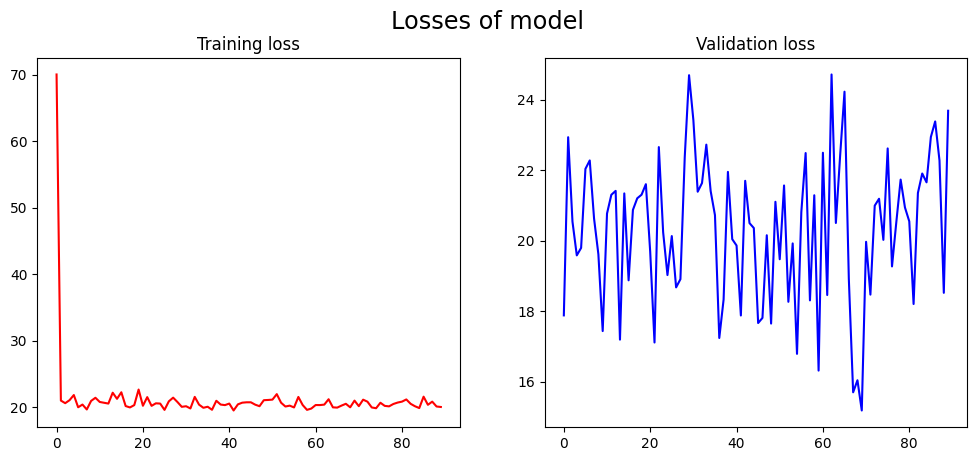

In [ ]:
import pylab as py

fig=py.figure()
fig.suptitle("Losses of model", size="xx-large")
ax=fig.add_subplot(1,2,1)
ax.set_title(f'Training loss')
ax.plot(range(len(train_loss)), train_loss, color='red')
ax=fig.add_subplot(1,2,2)
ax.set_title(f'Validation loss')
ax.plot(range(len(val_loss)), val_loss, color='blue')
fig.set_figwidth(12)

In [ ]:
# FOR LOADING SAVED MODEL

#pars=par()
#pars.device = device
#train,val,test=get_mnist()
# Initialize the network
#model = ScoreNet();
#net = Diffusion(model, pars.n_steps, pars.device, pars.min_beta, pars.max_beta)
# Post it to the gpu if it's there.
#net.to(pars.device)

# Load model from save state
#state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cuda:0')
#net.load_state_dict(state_dict)

## Code for sampling from the model

In [ ]:
# First, a per-step reverse sampling to get t-1 from t
def sample_step(net, xt, t):
  with torch.no_grad():
  # First, get mu
    mu = net.predict_next(xt.view(1, 1, 28, 28), t).view(784)
    # Next, extract alpha
    alphat = net.alpha[t - 1]
    std = torch.sqrt(1 - alphat)
    noise = torch.randn_like(xt).to(net.device)
    return (mu + std * noise)

# Now we can sample backwards from xT
def sample_model(net):
  xt = torch.randn(size=[784], device=net.device)
  T = net.n_steps
  for i in range(T, 0, -1):
    # Sample backwards at current step
    xt = sample_step(net, xt, torch.tensor(i))
  return xt

## Viewing samples and computing the FID score
First, to test the code of the previous part, we show images of about 20 samples.

In [ ]:
# Helper to display some chosen number of digits
def show_digits(examples, nrows, ncols, title):
  plt.figure(figsize=(ncols*2, nrows*2))
  plt.suptitle(title, size='xx-large')
  for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(examples[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
  plt.show()

In [ ]:
def sample_20_times(net):
  sample_list = []
  for i in range(20):
    sample_list.append(sample_model(net).cpu().detach().numpy())

  show_digits(sample_list, 5, 4, "Digits sampled from p(x0; θ)")

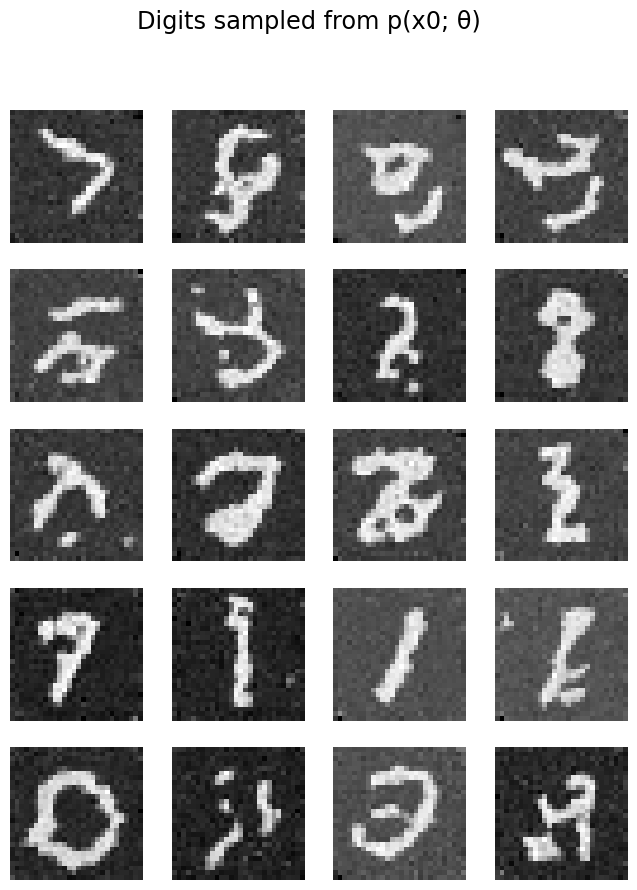

In [ ]:
sample_20_times(net)

Next, we pick 1000 random digits from MNIST and sample the model 1000 times, using both sets to estimate the FID score.

In [ ]:
# Calculate FID score
from scipy import linalg

def sqrt_mat(A):
  # For a symmetric matrix A w/ spectral decomposition A=ULU.T, define
  # A^{1/2} as U*sqrt(L)*U.T
  eigvals, eigenvecs = np.linalg.eig(A)
  return np.dot(np.dot(eigenvecs, np.diag(np.sqrt(eigvals))), eigenvecs.T)

def fid_dist_unused(G, D):
  # Frechet inception distance:
  # |mu_G - mu_D|^2 + tr[Sigma_G + Sigma_D - 2(Sigma_G^{1/2}*Sigma_D*Sigma_G^{1/2})^{1/2}]
  # note that if q = sqrt(Sigma_G)sqrt(Sigma_D), then we have -2(qT * q)^{1/2},
  # which is equivalent to -2q
  mu_g = np.mean(G)
  mu_d = np.mean(D)
  s_g = np.cov(G)
  s_d = np.cov(D)
  # first term, the distance between means
  dist = mu_g - mu_d
  term1 = dist**2
  # second term, the trace of covariances
  sqrt_s_g = sqrt_mat(s_g)
  term2 = np.trace(s_g + s_d - 2*sqrt_mat(sqrt_s_g @ s_d @ sqrt_s_g))

  return (term1 + term2)

def fid_dist(G, D):
  with torch.no_grad():
  # Frechet inception distance:
  # |mu_G - mu_D|^2 + tr[Sigma_G + Sigma_D - 2(Sigma_G^{1/2}*Sigma_D*Sigma_G^{1/2})^{1/2}]
    G = G.cpu().detach().numpy()
    D = D.cpu().detach().numpy()
    mu_g = np.mean(G, axis=0)
    mu_d = np.mean(D, axis=0)
    sigma_g = np.cov(G, rowvar=False)
    sigma_d = np.cov(D, rowvar=False)
    # first term, the distance between means
    dist = mu_g - mu_d
    covmean, _ = linalg.sqrtm(sigma_g.dot(sigma_d), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma_g.shape[0]) * 1e-6
        covmean = np.linalg.sqrtm((sigma_g + offset).dot(sigma_d + offset))
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            # raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return dist.dot(dist) + np.trace(sigma_g) + np.trace(sigma_d) - 2 * tr_covmean

In [ ]:
def sample_1000(net):
  # Next, sample 1000 times from net
  sampled_1000 = sample_model(net)
  torch.cuda.empty_cache()
  for i in range(999):
    if (i % 100 == 0):
      print(f"Sampled {i} times...")
    sampled_1000 = torch.vstack((sampled_1000, sample_model(net)))
    torch.cuda.empty_cache()

  print("Sampled 1000 times from model")
  return sampled_1000

In [ ]:
def compare_1000(sampled_1000):
  # First, grab 1000 random MNIST test images
  train_idxs = np.random.randint(len(train[1]), size=1000)
  mnist_1000 = torch.from_numpy(train[0][train_idxs]).to(device)
  print("Grabbed 1000 random test samples")
  # Calculate FID score
  fid_score = fid_dist(mnist_1000.reshape(1000, 784), sampled_1000)
  print(f"Calculated a FID score of {fid_score}")
  return fid_score

In [ ]:
# DO NOT RUN ME MORE THAN ONCE
# or you will be sitting at that computer for a long time...

v1_1000 = sample_1000(net)

Sampled 0 times...
Sampled 100 times...
Sampled 200 times...
Sampled 300 times...
Sampled 400 times...
Sampled 500 times...
Sampled 600 times...
Sampled 700 times...
Sampled 800 times...
Sampled 900 times...
Sampled 1000 times from model


In [ ]:
fid_v1 = compare_1000(v1_1000)

Grabbed 1000 random test samples
Calculated a FID score of 7.432162832908574


## Version 2
Here we create a new Diffusionv2 model without the $\rho_0, \rho_1$ terms when computing $\epsilon$. We also change the loss to match.

In [ ]:
class Diffusionv2(nn.Module):
  def __init__(self, model, n_steps, device, min_beta, max_beta, step_size = 0.01):
    super().__init__()
    self.compute_mean = model
    self.device = device
    self.n_steps = n_steps
    # Store beta, alpha and \bar alpha
    self.beta = torch.linspace(min_beta, max_beta, n_steps).to(device)
    self.alpha = 1.0 - self.beta
    self.bar_alpha = torch.cumprod(self.alpha, dim=0).to(device)
    self.optimizer = torch.optim.Adam([
      {'params': list(self.compute_mean.parameters()), 'lr': step_size}])

  def predict_next(self, xt, t):
    t = t.float().to(self.device)
    # Compute e(xt,t) using model
    # Need images of shape (channel x height x width)
    # = (1 x 28 x 28)
    # and need t as a column vector
    x = xt.reshape(xt.size(0), 1, 28, 28)
    h = self.compute_mean(x, t.view(-1, 1))
    return h

  # For each sample, draw a random integer between 1 and T
  # and then compute expectation
  def batch_loss(self, minibatch):
    batch_size = minibatch.size(0)
    # draw from 1 to T = num steps uniformly
    tj = torch.randint(1, self.n_steps, (batch_size,), device=self.device)
    # Get bar alphatj to produce x_tj
    bar_alpha_tj = self.bar_alpha[tj - 1].view(-1, 1)
    std_t = torch.sqrt(1 - bar_alpha_tj).view(-1, 1)
    noise_t = torch.randn_like(minibatch).to(self.device)
    x_tj = (torch.sqrt(bar_alpha_tj) * minibatch) + (torch.sqrt(1 - bar_alpha_tj) * noise_t)
    # Compute e(X_tj, tj, theta)
    e = self.predict_next(x_tj, tj)
    # Compute alpha_tj
    alpha_tj = self.alpha[tj - 1].view(-1, 1)
    # Compute loss: |noise - e|^2 * (1 - alpha_tj) / 2 * alphatj * (1 - bar_alpha_tj)
    diff = noise_t - e.view(batch_size,-1)
    numer = (1 - alpha_tj)
    denom = (2 * alpha_tj * (1 - bar_alpha_tj))
    loss = (diff.pow(2).sum(dim=1) * numer / denom).mean()
    return loss

  # Compute loss and then do a gradient step on the loss.
  def run_grad(self, data):

      self.optimizer.zero_grad()
      loss = self.batch_loss(data)
      loss.backward()
      self.optimizer.step()

      return loss

## Training the second version

In [ ]:
# use GPU when possible
pars = par()
pars.device = device
train,val,test=get_mnist()
# Initialize the network
model2 = ScoreNet().to(device);
net2 = Diffusionv2(model, pars.n_steps, pars.device, pars.min_beta, pars.max_beta)
# Post it to the gpu if it's there.
net2.to(pars.device)

train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

val_loss2 = []
train_loss2 = []

for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss2.append(run_epoch(net2,i,train, pars, num=pars.numtrain))
    # Test on validation set.
    val_loss2.append(net_test(net2,val,pars))
    # Slower learning rate
    net2.optimizer.param_groups[0]['lr'] = net2.optimizer.param_groups[0]['lr'] * 0.95

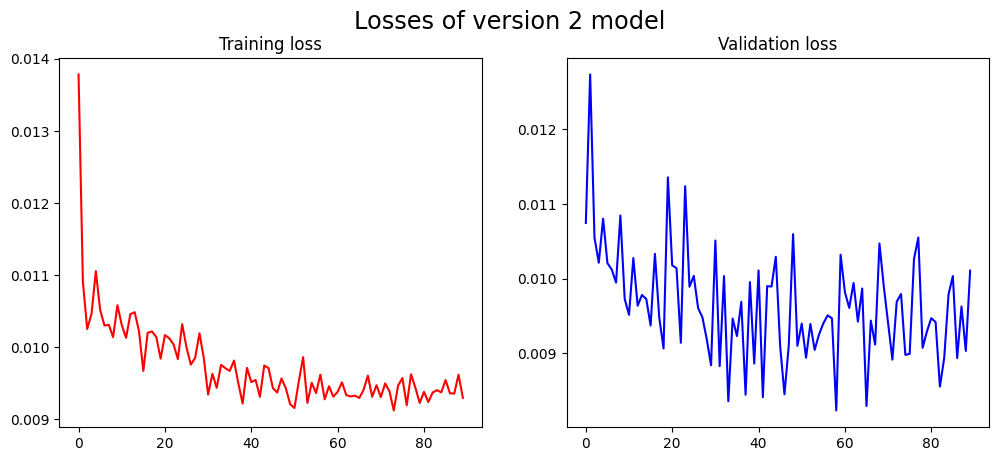

In [ ]:
fig=py.figure()
fig.suptitle("Losses of version 2 model", size="xx-large")
ax=fig.add_subplot(1,2,1)
ax.set_title(f'Training loss')
ax.plot(range(len(train_loss2)), train_loss2, color='red')
ax=fig.add_subplot(1,2,2)
ax.set_title(f'Validation loss')
ax.plot(range(len(val_loss2)), val_loss2, color='blue')
fig.set_figwidth(12)

## Sampling from the second version

In [ ]:
# First, a per-step reverse sampling to get t-1 from t
def sample_step_v2(net2, xt, t):
  with torch.no_grad():
    # First, get e
    e = net2.predict_next(xt, t)
    # Next, to get mu, we use equation (4), requiring alpha and bar_alpha
    alphat = net2.alpha[t - 1]
    bar_alphat = net2.bar_alpha[t - 1]
    # Outer coefficient
    outer_coeff = (1 / torch.sqrt(alphat))
    # Coefficient for just e_t
    inner_coeff = ((1 - alphat) / (torch.sqrt(1 - bar_alphat)))
    mu = (outer_coeff * (xt - (inner_coeff * e)))
    # Now, calculate standard dev
    std = torch.sqrt(1 - alphat)
    noise = torch.randn_like(xt).to(net2.device)
    return torch.clamp(mu + std * noise, -2, 2)

# Now we can sample backwards from xT
def sample_model_v2(net2, n):
  # Make size match necessary input for conv layer
  xt = torch.randn(size=[n, 1, 28, 28], device=net2.device)
  T = net2.n_steps
  showlist = xt.cpu()
  for i in range(T, 0, -1):
    # Sample backwards at current step
    xt = sample_step_v2(net2, xt, torch.tensor(i))
    showlist = torch.vstack((showlist, xt.cpu()))
  # For debugging: view progression of diffusion
  # show_digits(showlist, T, 5, "Diffusion progression (scroll down)")
  return xt

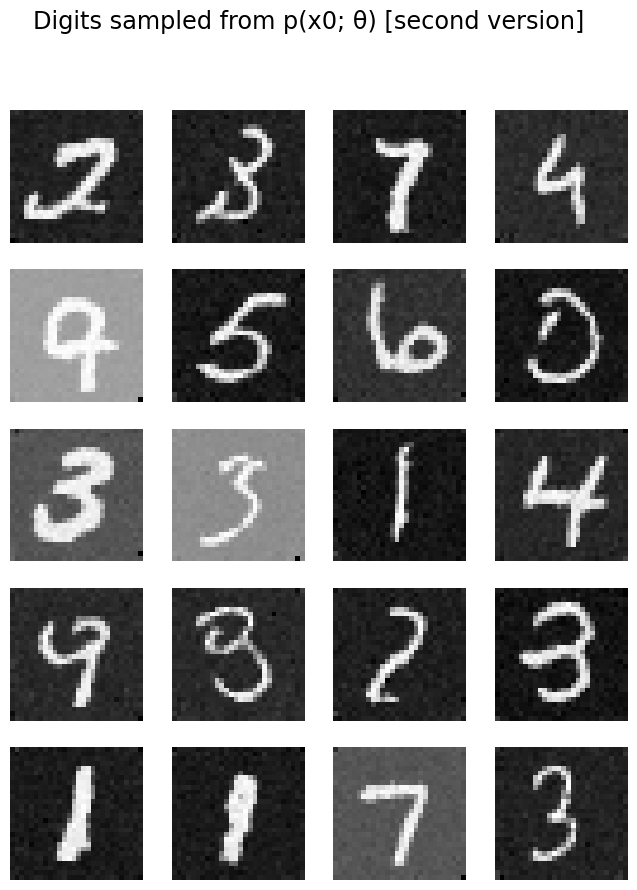

In [ ]:
show_digits(sample_model_v2(net2, 20).cpu(), 5, 4, "Digits sampled from p(x0; θ) [second version]")

In [ ]:
def compare_1000_v2(net2):
  # First, grab 1000 random MNIST test images
  train_idxs = np.random.randint(len(train[1]), size=1000)
  mnist_1000 = torch.from_numpy(train[0][train_idxs]).to(device)
  print("Grabbed 1000 random test samples")
  # Get 1000 samples
  sampled_1000 = sample_model_v2(net2, 1000)
  print("Sampled 1000 times from model")
  # Calculate FID score
  fid_score = fid_dist(mnist_1000.reshape(1000, 784), sampled_1000.reshape(1000, 784))
  print(f"Calculated a FID score of {fid_score}")
  return fid_score

In [ ]:
fid_v2 = compare_1000_v2(net2)

Grabbed 1000 random test samples
Sampled 1000 times from model
Calculated a FID score of 5.505834408432577


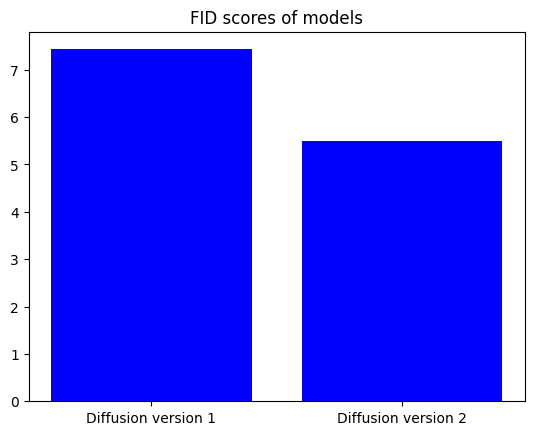

In [ ]:
plt.bar(["Diffusion version 1", "Diffusion version 2"],[fid_v1, fid_v2],color="blue")
plt.title('FID scores of models')
plt.show()

# Comments

Both versions do somewhat fine. The first version consistently produces distinct drawings on a distinct background, while the second version produces markings with varying values for both the drawing and the background. Maybe this could be because the extra scaling factors $\rho_0$ and $\rho_1$ help control the value and contrast after generating the image. Another issue I had was that the second version would denoise certain pixels to extreme values, which would then dominate the forward process. For example, a few pixels in the corner could be given extremely high weights relative to the rest of the background, and the digit would be indiscernible, since the difference between the rest of the background and the digit would be negligible compared to these overemphasized artifact pixels. To fix this, I had to clamp each step, which you can see in the `sample_step_v2` function. If you remove this, the images will often be black dots (artifacts) on a white background instead of the expected digit.

Both versions take about the same time to train, at 6 to 9 minutes for 90 epochs depening on which colab GPU, but while both versions sometimes produce strange-looking "digit-like" drawings which aren't actually digits, the second version more consistently produces realistic looking digits. This can be attributed to the difference in how the two versions model the paper. The first version is more "simple", and doesn't model the paper as closely as the second model, since it tries to model the mean $\mu$ directly with the two $\rho$ parameters. The second version better matches the paper, modeling $e(X_t, t; \theta)$ and properly deriving $\tilde\mu$, so it makes sense that the second model would be more realistic and have a lower FID score.